# Step 1
Import modules

In [1]:
''' import modules '''
import time
import argparse
import os.path as osp

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


from torchvision import datasets, transforms
from logger import Logger



# Step 2
Define an easy network

In [2]:
# Fully connected neural network with three hidden layer
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 320)
        self.fc2 = nn.Linear(320, 160)
        self.fc3 = nn.Linear(160, 80)
        self.fc4 = nn.Linear(80, 40)
        self.fc5 = nn.Linear(40, 10)
        self.fc1_bn = nn.BatchNorm1d(320)
        self.fc2_bn = nn.BatchNorm1d(160)
        self.fc3_bn = nn.BatchNorm1d(80)
        self.fc4_bn = nn.BatchNorm1d(40)
        self.fc1_gn = nn.GroupNorm(16,320)
        self.fc2_gn = nn.GroupNorm(8,160)
        self.fc3_gn = nn.GroupNorm(4,80)
        self.fc4_gn = nn.GroupNorm(2,40)
    def forward(self, x):
        x = x.view(-1,28*28)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = F.relu(self.fc3_bn(self.fc3(x)))
        x = F.relu(self.fc4_bn(self.fc4(x)))
        x = self.fc5(x)
        return F.log_softmax(x)
    

model = Net() 
model.cuda()

Net(
  (fc1): Linear(in_features=784, out_features=320, bias=True)
  (fc2): Linear(in_features=320, out_features=160, bias=True)
  (fc3): Linear(in_features=160, out_features=80, bias=True)
  (fc4): Linear(in_features=80, out_features=40, bias=True)
  (fc5): Linear(in_features=40, out_features=10, bias=True)
  (fc1_bn): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2_bn): BatchNorm1d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3_bn): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4_bn): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1_gn): GroupNorm(16, 320, eps=1e-05, affine=True)
  (fc2_gn): GroupNorm(8, 160, eps=1e-05, affine=True)
  (fc3_gn): GroupNorm(4, 80, eps=1e-05, affine=True)
  (fc4_gn): GroupNorm(2, 40, eps=1e-05, affine=True)
)

# Step 3
Hyper-parameters and data

In [3]:
''' Hyper-parameters'''
epochs = 10
batch_size = 1024
lr = 0.01
momentum = 0.5
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [4]:
''' Prapare data'''
kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))]
                   )),
    batch_size=batch_size, shuffle=True, **kwargs)


test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))]
                   )),
    batch_size=batch_size, shuffle=True, **kwargs)


# Step 4
Define train and validation function

In [5]:
''' Train and test'''

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # print(data.shape) [64,1,28,28]
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))


def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target).data[0]
        # get the index of the max log-probability
        pred = output.data.max(1)[1]
        correct += pred.eq(target.data).cpu().sum().double()

    # loss function already averages over batch size
    test_loss /= len(test_loader)
    acccuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, '
          'Accuracy: {}/{} ({:.1f}%)\n'.format(test_loss,
                                               correct,
                                               len(test_loader.dataset),
                                               acccuracy))
    return test_loss, acccuracy, data

def test_train(epoch):
    model.eval()
    train_loss = 0
    correct = 0.0
    for data, target in train_loader:
        
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        train_loss += F.nll_loss(output, target).data[0]
        # get the index of the max log-probability
        pred = output.data.max(1)[1]
        correct += pred.eq(target.data).cpu().sum().double()

    # loss function already averages over batch size
    train_loss /= len(train_loader)
    acccuracy = 100. * correct / len(train_loader.dataset)
    print('\nTrain set: Average loss: {:.4f}, '
          'Accuracy: {}/{} ({:.1f}%)\n'.format(train_loss,
                                               correct,
                                               len(train_loader.dataset),
                                               acccuracy))
    return train_loss, acccuracy, data


# Step 4.5 Visualize

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


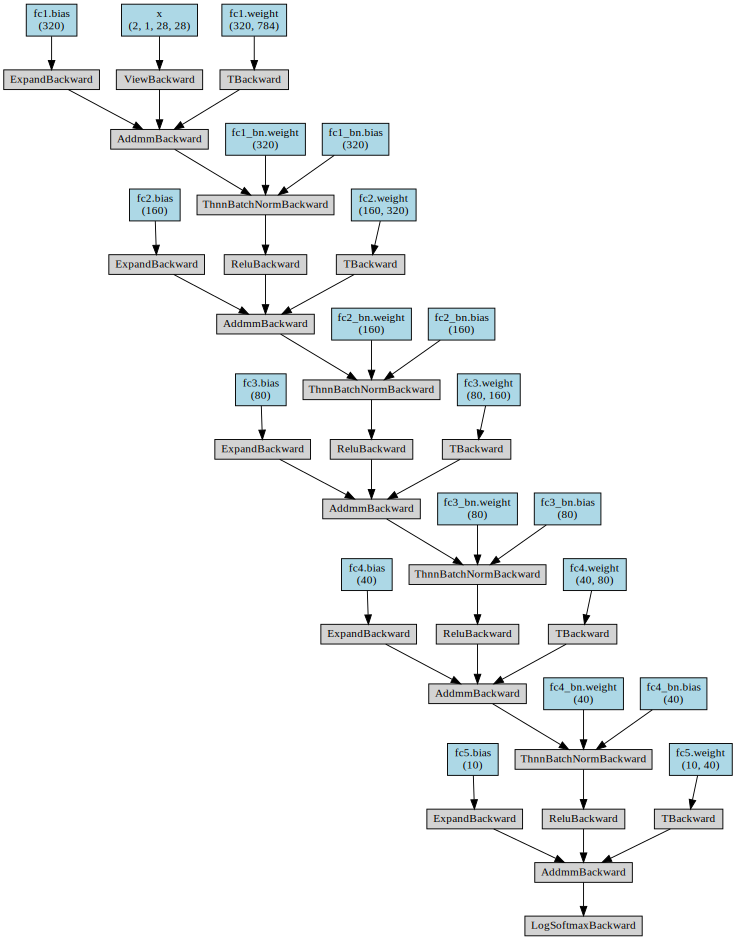

In [6]:
from torchviz import make_dot, make_dot_from_trace
x = Variable(torch.randn(2,1,28,28), requires_grad=True)
model.cpu()
y = model(x)
make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))

# Step 5
Train and record

In [7]:
''' train'''
model.cuda()
best_loss = None
logger_train = Logger('./logs/BatchN/1024b_trian')
logger_val = Logger('./logs/BatchN/1024b_val')
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(epoch)
    test_loss, test_acc, images = test(epoch)
    train_loss, train_acc, _ = test_train(epoch)
    print('-' * 89)
    timeLength = time.time() - epoch_start_time
    print('| end of epoch {:3d} | time: {:5.2f}s '.format(
        epoch, time.time() - epoch_start_time))
    print('-' * 89)
    best_loss = test_loss
    with open('model.pt', 'wb') as fp:
            state = model.state_dict()
            torch.save(state, fp)
    # ================================================================== #
    #                        Tensorboard Logging                         #
    # ================================================================== #
    # 1. Log scalar values (scalar summary)
    info = { 'loss': test_loss, 'accuracy': test_acc }
    for tag, value in info.items():
        logger_val.scalar_summary(tag, value, epoch+1)
    info = { 'loss': train_loss, 'accuracy': train_acc }
    for tag, value in info.items():
        logger_train.scalar_summary(tag, value, epoch+1)

    # 2. Log values and gradients of the parameters (histogram summary)
    '''for tag, value in model.named_parameters():
            tag = tag.replace('.', '/')
            logger_train.histo_summary(tag, value.data.cpu().numpy(), epoch+1)
            logger_train.histo_summary(tag+'/grad', value.grad.data.cpu().numpy(), epoch+1)
    '''
    # 3. Log training images (image summary)
    info = { 'images': images.view(-1, 28, 28)[:10].cpu().numpy() }

    for tag, images in info.items():
            logger_val.image_summary(tag, images, epoch+1)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.322242


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



Test set: Average loss: 1.5592, Accuracy: 7480.0/10000 (74.8%)



/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:51: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:53: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



Train set: Average loss: 1.5661, Accuracy: 44793.0/60000 (74.7%)

-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 13.53s 
-----------------------------------------------------------------------------------------
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.561542

Test set: Average loss: 1.1319, Accuracy: 8608.0/10000 (86.1%)


Train set: Average loss: 1.1440, Accuracy: 51321.0/60000 (85.5%)

-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 11.54s 
-----------------------------------------------------------------------------------------
Train Epoch: 3 [0/60000 (0%)]	Loss: 1.154360

Test set: Average loss: 0.8025, Accuracy: 9060.0/10000 (90.6%)


Train set: Average loss: 0.8151, Accuracy: 54176.0/60000 (90.3%)

-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 11.80s 
------------------------

In [8]:
done = True
